In [55]:
import openfermion
import openfermionpyscf
from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.transforms import get_fermion_operator
from openfermion.circuits import (uccsd_singlet_get_packed_amplitudes,
                               uccsd_singlet_generator, uccsd_generator,
                               uccsd_convert_amplitude_format)
import numpy as np
import cs_vqe as c
import itertools
import qubit_conversion as q_conv

In [2]:
import ast
import matplotlib
import matplotlib.pyplot as plt

f = open("hamiltonians.txt","r")
hamiltonians = ast.literal_eval(f.read())
f.close()

for h in hamiltonians.keys():
    print(h, '# qubits:', hamiltonians[h][1], 'A terms:', hamiltonians[h][5][3][1])

H2-S1_STO-3G_singlet # qubits: 18 A terms: ['IIZZZZZZZXIIIIIIII', 'IIIIIIIIIZIIIIIIII']
C1-O1_STO-3G_singlet # qubits: 16 A terms: ['IIZZZZZXIIIIIIII', 'IIIIIIIZIIIIIIII']
H1-Cl1_STO-3G_singlet # qubits: 16 A terms: ['IIZZZZZXIIIIIIII', 'IIIIIIIZIIIIIIII']
H1-Na1_STO-3G_singlet # qubits: 16 A terms: ['IIZZZZZZZXIIIIII', 'IIIIIIIIIZIIIIII']
H2-Mg1_STO-3G_singlet # qubits: 17 A terms: ['IIIZZIIZXZZIIZZZZ', 'IIIIIIIIZIIIIIIII']
H1-F1_3-21G_singlet # qubits: 18 A terms: ['IIIIZZZZZXZZIIIIII', 'IIZIIIIIZZIIIIIIII']
H1-Li1_3-21G_singlet # qubits: 18 A terms: ['IIIIZZZZIIZXIIIIII', 'IIZIIIIIIIZZIIIIII']
Be1_STO-3G_singlet # qubits: 5 A terms: ['IIIXI', 'IIIZI']
H1-F1_STO-3G_singlet # qubits: 8 A terms: ['IIXZZZZZ', 'IIZIIIII']
H1-Li1_STO-3G_singlet # qubits: 8 A terms: ['IIIIIXZZ', 'ZZIZIZIZ']
Ar1_STO-3G_singlet # qubits: 13 A terms: ['IIIZZZZZXZZZZ', 'IIIIIIIIZIIII']
F2_STO-3G_singlet # qubits: 15 A terms: ['IIIIIIIIIIIIZII', 'IIIIIIIIIIIXXYY']
H1-O1_STO-3G_singlet # qubits: 8 A terms: ['IIX

In [53]:
speciesname = 'H1-He1_STO-3G_singlet'

encoding = hamiltonians[speciesname][0] # in this dataset, always 'JW' for Jordan-Wigner, but leaves room for trying Bravyi-Kitaev as well
num_qubits = hamiltonians[speciesname][1] # number of qubits (all of these Hamiltonians have been tapered for molecular symmetries)
ham = hamiltonians[speciesname][2] # full Hamiltonian
ham_noncon = hamiltonians[speciesname][3] # noncontextual part of Hamiltonian, found by greedy DFS
true_gs = hamiltonians[speciesname][4] # ground state energy of full Hamiltonian (in Hartree)
gs_noncon = hamiltonians[speciesname][5] # list containing information about noncontextual ground state: zeroth entry is ground state energy of noncontextual part of Hamiltonian
#print('commuting generators:',model[0], '\n')
#print('anticommuting generators:',model[1], '\n')
#print('term reconstruction:',model[2], '\n')

print('number of qubits:', num_qubits)
print('true ground state energy:', true_gs)
print('noncontextual approximation to ground state energy:', gs_noncon[0])
print(ham_noncon)

number of qubits: 2
true ground state energy: -4.001240607721688
noncontextual approximation to ground state energy: -3.9930146990720448
{'II': -3.0847221710636843, 'IZ': 0.5160798861830592, 'ZI': 0.5160798861830591, 'ZZ': 0.12386724435775806, 'XZ': -0.11608931078542636, 'XI': -0.1160893107234352}


In [56]:
import openfermion
import openfermionpyscf
from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.transforms import get_fermion_operator
from openfermion.circuits import (uccsd_singlet_get_packed_amplitudes,
                               uccsd_singlet_generator, uccsd_generator,
                               uccsd_convert_amplitude_format)
import numpy as np
import cs_vqe as c
import itertools
import qubit_conversion as q_conv

singlet_bool = True # Set general UCCSD or singlet UCCSD.

bond_len = 0.772#1.45
atom_1 = 'He'
atom_2 = 'H'
basis = '3-21g'
multiplicity = 1
charge = 1

coordinate_1 = (0.0, 0.0, 0.0)
coordinate_2 = (0.0, 0.0, bond_len)
geometry = [(atom_1, coordinate_1), (atom_2, coordinate_2)]

molecule_data = MolecularData(geometry, basis, multiplicity, charge, description='Test')
#molecule.load()

# Set calculation parameters.
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1
delete_input = True
delete_output = True

# Run pyscf.
molecule = run_pyscf(molecule_data,
                     run_scf=run_scf,
                     run_mp2=run_mp2,
                     run_cisd=run_cisd,
                     run_ccsd=run_ccsd,
                     run_fci=run_fci)

#molecule.load()
#print(molecule)

ham = get_fermion_operator(molecule.get_molecular_hamiltonian())
ham_q = jordan_wigner(ham)
print('Hamiltonian:', '\n', ham_q, '\n')

scf = True      # Hartree-Fock.
mp2 = True      # Moller-Plesset 2.
cisd = True     # Configuration interaction singles and doubles.
ccsd = True     # Coupled cluster singles and doubles.
fci = True      # Full configuration interaction.

calculated_molecule = run_pyscf(molecule_data, scf, mp2, cisd, ccsd, fci)

if ccsd:
    ccsd_single_amps = calculated_molecule.ccsd_single_amps
    ccsd_double_amps = calculated_molecule.ccsd_double_amps

num_electrons = calculated_molecule.n_electrons
num_qubits = 2*calculated_molecule.n_orbitals

if singlet_bool:
    # Get singlet UCCSD generator.
    packed_amps = uccsd_singlet_get_packed_amplitudes(ccsd_single_amps,  ccsd_double_amps, num_qubits, num_electrons)
    ucc_sing = uccsd_singlet_generator(packed_amps, num_qubits, num_electrons)
    #print(ucc_sing)

else:
    # Get general UCCSD operator.
    ucc_op = uccsd_generator(ccsd_single_amps, ccsd_double_amps)
    #print(ucc_op)
    
ucc_q = jordan_wigner(ucc_sing)
print('UCCSD ansatz:', '\n', ucc_q)

Hamiltonian: 
 (1.1324434021069396+0j) [] +
(-0.02581025441481505+0j) [X0 X1 Y2 Y3] +
(-0.012799934786437012+0j) [X0 X1 Y2 Z3 Z4 Y5] +
(-0.025159645839897923+0j) [X0 X1 Y2 Z3 Z4 Z5 Z6 Y7] +
(-0.012799934786437012+0j) [X0 X1 X3 X4] +
(-0.025159645839897923+0j) [X0 X1 X3 Z4 Z5 X6] +
(-0.01711452882177465+0j) [X0 X1 Y4 Y5] +
(-0.0009891049103627398+0j) [X0 X1 Y4 Z5 Z6 Y7] +
(-0.0009891049103627398+0j) [X0 X1 X5 X6] +
(-0.054698565746849274+0j) [X0 X1 Y6 Y7] +
(0.02581025441481505+0j) [X0 Y1 Y2 X3] +
(0.012799934786437012+0j) [X0 Y1 Y2 Z3 Z4 X5] +
(0.025159645839897923+0j) [X0 Y1 Y2 Z3 Z4 Z5 Z6 X7] +
(-0.012799934786437012+0j) [X0 Y1 Y3 X4] +
(-0.025159645839897923+0j) [X0 Y1 Y3 Z4 Z5 X6] +
(0.01711452882177465+0j) [X0 Y1 Y4 X5] +
(0.0009891049103627398+0j) [X0 Y1 Y4 Z5 Z6 X7] +
(-0.0009891049103627398+0j) [X0 Y1 Y5 X6] +
(0.054698565746849274+0j) [X0 Y1 Y6 X7] +
(0.002577905179412112+0j) [X0 Z1 X2] +
(0.004766148105680643+0j) [X0 Z1 X2 X3 Z4 X5] +
(-0.009264702923307932+0j) [X0 Z1 X2 X3 Z

UCCSD ansatz: 
 0.006478936130102838j [X0 X1 X2 Y3] +
0.006478936130102838j [X0 X1 Y2 X3] +
0.0020562744029710704j [X0 X1 X4 Y5] +
0.0020562744029710704j [X0 X1 Y4 X5] +
0.005083283191416048j [X0 X1 X6 Y7] +
0.005083283191416048j [X0 X1 Y6 X7] +
-0.006478936130102838j [X0 Y1 X2 X3] +
0.006478936130102838j [X0 Y1 Y2 Y3] +
-0.0020562744029710704j [X0 Y1 X4 X5] +
0.0020562744029710704j [X0 Y1 Y4 Y5] +
-0.005083283191416048j [X0 Y1 X6 X7] +
0.005083283191416048j [X0 Y1 Y6 Y7] +
-0.006360390047729467j [X0 Z1 Y2] +
-0.002645411873769119j [X0 Z1 Z2 Z3 Y4] +
0.0009221551709274561j [X0 Z1 Z2 Z3 Z4 Z5 Y6] +
-0.006478936130102838j [Y0 X1 X2 X3] +
0.006478936130102838j [Y0 X1 Y2 Y3] +
-0.0020562744029710704j [Y0 X1 X4 X5] +
0.0020562744029710704j [Y0 X1 Y4 Y5] +
-0.005083283191416048j [Y0 X1 X6 X7] +
0.005083283191416048j [Y0 X1 Y6 Y7] +
-0.006478936130102838j [Y0 Y1 X2 Y3] +
-0.006478936130102838j [Y0 Y1 Y2 X3] +
-0.0020562744029710704j [Y0 Y1 X4 Y5] +
-0.0020562744029710704j [Y0 Y1 Y4 X5] +
-0.0

In [57]:
ham = q_conv.QubitOperator_to_dict(ham_q, num_qubits)
anz_terms = list((q_conv.QubitOperator_to_dict(ucc_q, num_qubits)).keys())
terms_noncon = c.greedy_dfs(ham, 1, criterion='weight')[-1]
ham_noncon = {t:ham[t] for t in terms_noncon}
#ham_noncon
terms_context = list(ham.keys() - terms_noncon)
ham_context = {t:ham[t] for t in terms_context}
#ham_context
c.contextualQ_ham(ham_context)

True

In [58]:
from qiskit.aqua.algorithms import NumPyEigensolver

result = NumPyEigensolver(q_conv.dict_to_WeightedPauliOperator(ham)).run()
true_gs = np.real(result.eigenvalues)

print(true_gs)

[-3.16676548]


In [59]:
model = c.quasi_model(ham_noncon)
fn_form = c.energy_function_form(ham_noncon, model)
gs_noncon = c.find_gs_noncon(ham_noncon)
gs_noncon_energy = gs_noncon[0]
ep_state = gs_noncon[1]
ham_context = {p:c for p,c in ham.items() if p not in ham_noncon}
c.csvqe_approximations_heuristic(ham, ham_noncon, num_qubits, true_gs)
#c.contextualQ_ham(ham_context)

[array([-3.16676548]),
 [-3.142824749268174,
  -3.151872881862979,
  -3.151872881862984,
  -3.1557103882871225,
  -3.159114851913751,
  -3.1591148519137566,
  -3.1619490056505186,
  -3.1667654772544034,
  -3.1667654772544074],
 [array([0.02394073]),
  array([0.0148926]),
  array([0.0148926]),
  array([0.01105509]),
  array([0.00765063]),
  array([0.00765063]),
  array([0.00481647]),
  array([-1.77635684e-15]),
  array([-5.77315973e-15])],
 [6, 2, 0, 4, 1, 3, 5, 7]]

In [61]:
model[0:2], gs_noncon_energy, ep_state

((['ZIIIIIZI',
   'IZIIIIIZ',
   'IIZIIIII',
   'IIIZIIII',
   'IIIIZIII',
   'IIIIIZII',
   'IIIIIIIZ'],
  ['YZZZZZYZ', 'IIIIIIZI']),
 -3.1428247492681742,
 [[-1, -1, 1, -1, 1, 1, 1], [0.04017214144809311, 0.9991927737186025]])

# The epistemic state defines a classical probability distribution:

In [62]:
def ontic_prob(ep_state, ontic_state):
    
    if ep_state[0] != ontic_state[0]:
        return 0
    
    else:
        prod = 1
        for index, r in enumerate(ep_state[1]):
            f = 1/2 * abs(r + ontic_state[1][index])
            prod *= f
        
        return prod    

def epistemic_dist(ep_state):
    size_G = len(ep_state[0])
    size_Ci = len(ep_state[1])
    size_R = size_G + size_Ci
    
    ep_prob = {}
    
    ontic_states = list(itertools.product([1, -1], repeat=size_R))
    
    for o in ontic_states:
        o_state = [list(o[0:size_G]), list(o[size_G:size_R])]
        o_prob = ontic_prob(ep_state, o_state)
        
        if o_prob != 0:
            ep_prob[o] = o_prob
    
    return ep_prob

In [63]:
epistemic_dist(ep_state)

{(-1, -1, 1, -1, 1, 1, 1, 1, 1): 0.519876157151608,
 (-1, -1, 1, -1, 1, 1, 1, 1, -1): 0.00020991357243860741,
 (-1, -1, 1, -1, 1, 1, 1, -1, 1): 0.4797202297076933,
 (-1, -1, 1, -1, 1, 1, 1, -1, -1): 0.0001936995682601479}

# Find a simultaneous eigenstate of the operators G_i and A:

In [323]:
from copy import deepcopy

G = model[0]
fixed_qubits = ['I' for i in range(num_qubits)]
basis_ops = []
mult_Z_indices = []

for index, g in enumerate(G):
    Z_indices = [i for i, p in enumerate(list(g)) if p == 'Z']
    if len(Z_indices) == 1:
        if ep_state[0][index] == -1:
            fixed_qubits[Z_indices[0]] = 1
        else:
            fixed_qubits[Z_indices[0]] = 0
    else:
        mult_Z_indices.append([ep_state[0][index], Z_indices])
        
print(fixed_qubits)

for Z_indices in mult_Z_indices:
    Z0, Z1 = Z_indices[1][0], Z_indices[1][1] 
    q0, q1 = fixed_qubits[Z0], fixed_qubits[Z1]
    
    if q0 != q1:
        if q0 != 'I':
            if Z_indices[0] == -1:
                fixed_qubits[Z1] = (q0+1)%2
            else:
                fixed_qubits[Z1] = q0
        else:
            if Z_indices[0] == -1:
                fixed_qubits[Z0] = (q1+1)%2
            else:
                fixed_qubits[Z0] = q1
        mult_Z_indices.remove(Z_indices)
            
for Z_indices in mult_Z_indices:
    if Z_indices[0] == -1:
        fixed = deepcopy(fixed_qubits)
        fixed[Z_indices[1][0]] = 0
        fixed[Z_indices[1][1]] = 1
        fixed = [str(i) for i in fixed]
        basis_ops.append(''.join(fixed))
        
        fixed = deepcopy(fixed_qubits)
        fixed[Z_indices[1][0]] = 1
        fixed[Z_indices[1][1]] = 0
        fixed = [str(i) for i in fixed]
        basis_ops.append(''.join(fixed))
    
print(basis_ops)

['I', 'I', 0, 1, 0, 0, 'I', 0]
['01010010', '11010000']


# Construct +1-Eigenstates of A(r)

In [65]:
r1 = ep_state[1][0]
r2 = ep_state[1][1]
#t = np.arctan((r2 + 1) / r1)
r1, r2

(0.04017214144809311, 0.9991927737186025)

In [230]:
import itertools
from copy import deepcopy

def bin_to_int(bits):
    bit_string = deepcopy(bits)
    
    if type(bit_string) == str:
        bit_string = [int(b) for b in bit_string]
        
    for index, b in enumerate(bit_string):
        bit_string[index] = b * 2 ** (len(bit_string)-index-1)
    
    return sum(bit_string)


def add_eigenstate(r1, r2, index, theta, n, num_qubits):
    """
    """
    B = list(itertools.product([0,1], repeat=num_qubits))
    b1 = list(B[index])
    b2 = deepcopy(b1)
    b2[0] = (b2[0]+1)%2
    b2[6] = (b2[6]+1)%2
    i1 = bin_to_int(b1)
    i2 = bin_to_int(b2)
    
    parity=sum(b1)
    q1 = b1[6]
    
    amp_ratio = (1 + r2 * (-1)**q1) / (r1 * (-1)**(1 + parity))
    t = ((-1)**n)*np.arctan(amp_ratio)
    
    psi = [0 for i in range(2**num_qubits)]
    psi[i1] = np.sin(t)*np.exp(1j*theta)
    psi[i2] = np.cos(t)*np.exp(1j*(theta - n*np.pi))

    return np.array(psi)

#psi = add_eigenstate(r1=r1, r2=r2, index=82, num_qubits=num_qubits)

In [330]:
from openfermion.linalg import LinearQubitOperator

ham_q = q_conv.dict_to_QubitOperator(ham, num_qubits)
ham_noncon_q = q_conv.dict_to_QubitOperator(ham_noncon, num_qubits)
ham_context_q = q_conv.dict_to_QubitOperator(ham_context, num_qubits)

#take expectation value algebraically
for t in np.linspace(0, 3, 0.1):
    H = LinearQubitOperator(ham_context_q, num_qubits)
    psi = add_eigenstate(r1=r1, r2=r2, index=82, theta=t, n=0, num_qubits=num_qubits)
    psi_conj = np.conjugate(psi)

    H_psi = H.matvec(psi)
    expect = psi_conj.dot(H_psi)

    print('<H> w.r.t. simultaneous eigenstate:', expect)
    print('Noncontextual approximation:', gs_noncon_energy)
    print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match?

TypeError: 'float' object cannot be interpreted as an integer

/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


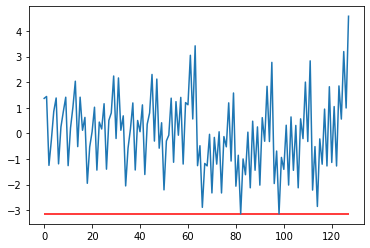

In [303]:
from matplotlib import pyplot as plt

X=[]
Y=[]

H = LinearQubitOperator(ham_q, num_qubits)

for i in range(2**(num_qubits-1)):
    X.append(i)
    psi = add_eigenstate(r1=r1, r2=r2, index=i, theta=0, n=0, num_qubits=num_qubits)
    psi_conj = np.conjugate(psi)
    
    H_psi = H.matvec(psi)
    expect = psi_conj.dot(H_psi)
    Y.append(expect)

plt.plot(X, Y)
plt.hlines(gs_noncon_energy, 0, 127, color='r')
plt.show()

In [304]:
import math

def random_vector(n):
    components = [np.random.normal() for i in range(n)]
    r = math.sqrt(sum(x*x for x in components))
    v = [x/r for x in components]
    return v

/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


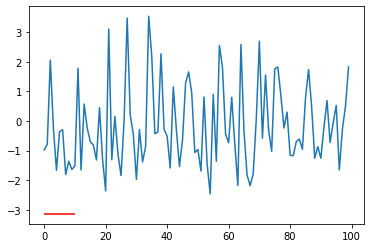

In [321]:
#take expectation value algebraically
shots=100

H = LinearQubitOperator(ham_q, num_qubits)
X=[random_vector(5) for i in range(shots)]
indices = [83, 84, 85, 127, 82]
Y=[]

A_op = QubitOperator('Y0 Z1 Z2 Z3 Z4 Z5 Y6 Z7', r1) + QubitOperator('Z6', r2)
A = LinearQubitOperator(A_op, num_qubits)

for p in X:
    psi = np.array([0 for i in range(2**num_qubits)], dtype=complex)
    for index, i in enumerate(indices):
        psi += (p[index])*add_eigenstate(r1=r1, r2=r2, theta=2*i, n=i, index=i, num_qubits=num_qubits)
    psi_conj = np.conjugate(psi)
    
    H_psi = H.matvec(psi)
    expect = psi_conj.dot(H_psi)
    Y.append(expect)
    
    #Verify +1-eigenstate
    #A_psi = A.matvec(psi)
    #print(psi_conj.dot(A_psi))

plt.plot(range(shots), Y)
plt.hlines(gs_noncon_energy, 0, 10, color='r')
#print('<H> w.r.t. simultaneous eigenstate:', expect)
#print('Noncontextual approximation:', gs_noncon_energy)
#print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match? 

# Do we have any quantum corrections?

In [52]:
G = model[0]
terms_context = list(ham_context.keys())
G

['ZIIIIIIIII',
 'IZIIIIIIII',
 'IIZIIIIIII',
 'IIIZIIIIII',
 'IIIIZIIIII',
 'IIIIIIZIII',
 'IIIIIIIZII',
 'IIIIIIIIZI',
 'IIIIIIIIIZ']

In [53]:
q_corr_terms = []
for t in terms_context:
    commutes = []
    for g in G:
        if c.commute(t, g):
            commutes.append(g)
    #print(t, 'commutes with the noncontextual generators:', commutes)
    if commutes == G:
        q_corr_terms.append(t)
        
if q_corr_terms == []:
    print('No quantum correction')
else:
    print('Terms admitting quantum correction:', q_corr_terms)

No quantum correction


In [54]:
#psi2 = [0 for i in range(2**num_qubits)]
#psi2[bin_to_int('000011')] = np.sin(t)
#psi2[bin_to_int('010111')] = -np.cos(t)

In [55]:
#from qiskit import QuantumCircuit
#from qiskit.extensions import Initialize
#from qiskit.circuit import Parameter

#anz = QuantumCircuit(num_qubits) # We are redefining qc
#anz.initialize(psi)
#anz.ry(Parameter('x'), 3)
#anz.initialize(psi2)
#anz.rx(Parameter('y'), 3)

In [56]:
#from qiskit.utils import QuantumInstance, algorithm_globals
#from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
#from qiskit.algorithms import VQE
#from qiskit.quantum_info.operators.symplectic.pauli import Pauli
#from qiskit.opflow.primitive_ops import PauliOp
#from qiskit import Aer

#ham_qiskit = sum([PauliOp(Pauli(k), ham[k]) for k in ham.keys()])

#seed = 50
#algorithm_globals.random_seed = seed
#qi = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)
#slsqp = SLSQP(maxiter=1000)

#vqe = VQE(anz, optimizer=slsqp, quantum_instance=qi)
#vqe_run    = vqe.compute_minimum_eigenvalue(operator=ham_qiskit)
#vqe_result = vqe_run.optimal_value# + shift

#print('VQE:', vqe_result, '|', 'Noncontextual Ground State:', gs_noncon_energy, 'True Ground State:', true_gs)

In [57]:
from qiskit.aqua.algorithms import NumPyEigensolver

order = [0,1,2,3,4,5,6,7]
print(c.contextual_subspace_approximations(ham,model,fn_form,ep_state,order))

result = NumPyEigensolver(q_conv.dict_to_WeightedPauliOperator(ham)).run()
exact_energy = np.real(result.eigenvalues)

print(exact_energy)

[-83.8742239006154, -83.87422390061546, -83.8758195779362, -83.88240004021091, -83.89086618279309, -83.91323713466015, -83.91937617916174, -83.92862837750964, -83.92865354102884]
[-83.92870248]


In [58]:
rotations = (c.diagonalize_epistemic(model,fn_form,ep_state))[0]
rotations

[]

In [59]:
from copy import deepcopy

rot_psi = deepcopy(psi)

for r in rotations:
    r_op = LinearQubitOperator(QubitOperator('', 1/np.sqrt(2)) + q_conv.dict_to_QubitOperator({r[1]: -1/np.sqrt(2)*1j}, num_qubits), num_qubits)
    rot_psi = r_op.matvec(rot_psi)
    
#print(rot_psi)

In [60]:
from openfermion.linalg import LinearQubitOperator

rot_psi = np.array(rot_psi)
rot_ham = c.get_reduced_hamiltonians(ham,model,fn_form,ep_state,order=[0,1,2,3,4,5,6,7])[8]
rot_ham_q = q_conv.dict_to_QubitOperator(rot_ham, num_qubits)

#take expectation value algebraically
rot_H = LinearQubitOperator(rot_ham_q, num_qubits)
rot_H_psi = rot_H.matvec(rot_psi)
rot_expect = rot_psi.dot(rot_H_psi)

print('<H> w.r.t. simultaneous eigenstate:', rot_expect)
print('Noncontextual approximation:', gs_noncon_energy)
print('Expectation values match?', abs(rot_expect - gs_noncon_energy) < 10**-14) #sanity check - expectation values match? 

<H> w.r.t. simultaneous eigenstate: (-83.87422390061546+0j)
Noncontextual approximation: -83.87422390061549
Expectation values match? False


In [61]:
rot_psi.dot(rot_H.matvec(rot_psi)), psi.dot(H.matvec(psi))

((-83.87422390061546+0j), (-83.87422390061543+0j))

array([ True,  True,  True, ...,  True,  True,  True])

In [9]:
def bin_to_int(bits):
    if type(bits) == str:
        bits = [int(b) for b in bits]
    for index, b in enumerate(bits):
        bits[index] = b * 2 ** (len(bits)-index-1)
    return sum(bits)

In [27]:
from copy import deepcopy

v1 = [0,0,0,0,1,1,1,1]
v2 = deepcopy(v1)
v2[0] = (v2[0]+1)%2
v2[6] = (v2[6]+1)%2

In [28]:
bin_to_int(v1), bin_to_int(v2)

(15, 141)

0 130 130
1 131 130
2 128 126
3 129 126
4 134 130
5 135 130
6 132 126
7 133 126
8 138 130
9 139 130
10 136 126
11 137 126
12 142 130
13 143 130
14 140 126
15 141 126
16 146 130
17 147 130
18 144 126
19 145 126
20 150 130
21 151 130
22 148 126
23 149 126
24 154 130
25 155 130
26 152 126
27 153 126
28 158 130
29 159 130
30 156 126
31 157 126
32 162 130
33 163 130
34 160 126
35 161 126
36 166 130
37 167 130
38 164 126
39 165 126
40 170 130
41 171 130
42 168 126
43 169 126
44 174 130
45 175 130
46 172 126
47 173 126
48 178 130
49 179 130
50 176 126
51 177 126
52 182 130
53 183 130
54 180 126
55 181 126
56 186 130
57 187 130
58 184 126
59 185 126
60 190 130
61 191 130
62 188 126
63 189 126
64 194 130
65 195 130
66 192 126
67 193 126
68 198 130
69 199 130
70 196 126
71 197 126
72 202 130
73 203 130
74 200 126
75 201 126
76 206 130
77 207 130
78 204 126
79 205 126
80 210 130
81 211 130
82 208 126
83 209 126
84 214 130
85 215 130
86 212 126
87 213 126
88 218 130
89 219 130
90 216 126
91 217 12

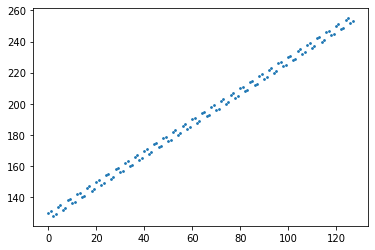

In [51]:
import itertools
from matplotlib import pyplot as plt

B = list(itertools.product([0,1], repeat=8))

X=[]
Y=[]

for b1 in B[0:128]:
    b1 = list(b1)
    b2 = deepcopy(b1)
    b2[0] = (b2[0]+1)%2
    b2[6] = (b2[6]+1)%2
    i1 = bin_to_int(b1)
    i2 = bin_to_int(b2)
    X.append(i1)
    Y.append(i2)
    print(i1, i2, i2-i1)
    
plt.scatter(X, Y, s=3)

In [198]:
np.exp(0.6*1j)

(0.8253356149096783+0.5646424733950354j)

In [277]:
sorted([0, 5, -3], key=abs)

[0, -3, 5]

361